In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
from tensorflow import keras as k
import tensorflow as tf
import pathlib 
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization,SeparableConv2D
from warnings import filterwarnings
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.utils import plot_model
filterwarnings("ignore")

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_virtual_device_configuration(
            gpu,
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])  # Limit to 1GB GPU memory


In [4]:
train_path = r"C:\Users\pirat\Desktop\archive (5)\chest_xray\train"
test_path = r"C:\Users\pirat\Desktop\archive (5)\chest_xray\test"
val_path = r"C:\Users\pirat\Desktop\archive (5)\chest_xray\val"

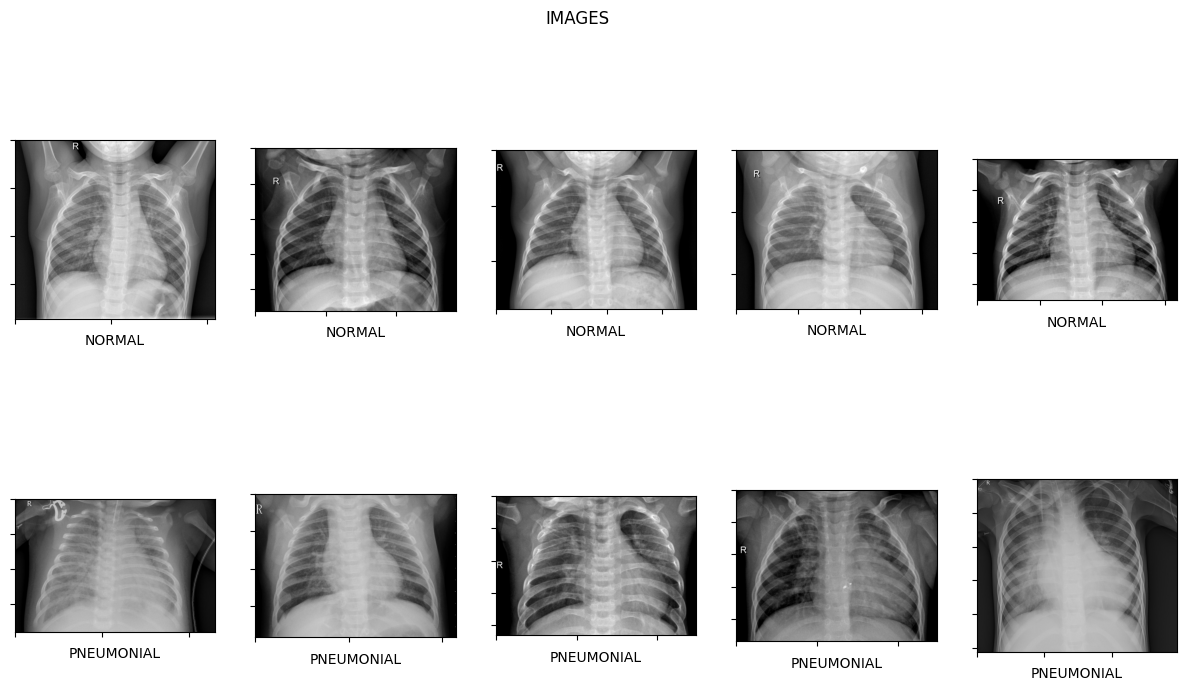

In [5]:
fig,axes = plt.subplots(nrows=2,ncols=5,figsize=(15,8))
train_path = Path(train_path)
paths = list(train_path.iterdir())
normal_train = Path(paths[0])
pneumonia_train = Path(paths[1])
rows=0
cols=0
normal_images = [str(i) for i in normal_train.iterdir()][:5]
diseas_images = [str(i) for i in pneumonia_train.iterdir()][:5]
for i in normal_images:
    img_data = cv.imread(i)
    axes[rows][cols].imshow(img_data)
    axes[rows][cols].axes.set_xticklabels([])
    axes[rows][cols].axes.set_yticklabels([])
    axes[rows][cols].axes.set_xlabel("NORMAL")
    cols+=1
rows+=1
cols=0
for i in diseas_images:
    img_data = cv.imread(i)
    axes[rows][cols].imshow(img_data)
    axes[rows][cols].axes.set_xticklabels([])
    axes[rows][cols].axes.set_yticklabels([])
    axes[rows][cols].axes.set_xlabel("PNEUMONIAL")
    cols+=1
fig.suptitle("IMAGES")
fig.show()

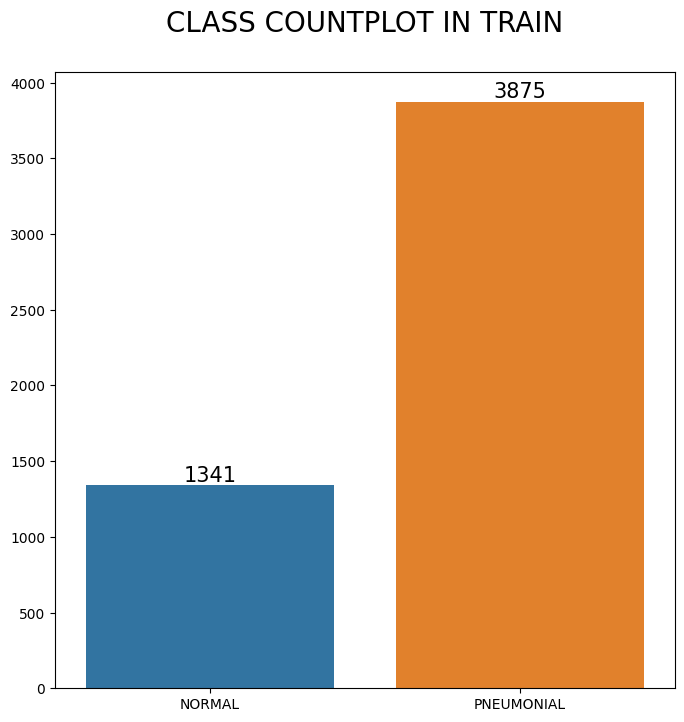

In [6]:
plt.figure(figsize=(8,8))
counts = {"NORMAL":sum(1 for i in normal_train.iterdir()),"PNEUMONIAL":sum(1 for i in pneumonia_train.iterdir())}
ax = sns.barplot(x = list(counts.keys()),y = list(counts.values()))
for i in ax.containers:
    ax.bar_label(i,fontsize=15)
plt.title("CLASS COUNTPLOT IN TRAIN\n",fontsize=20)
plt.show()

In [7]:
image_generator = k.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

In [8]:
train= image_generator.flow_from_directory(train_path,
                                            batch_size=15,
                                            class_mode="binary",                                           
                                            shuffle=True,
                                            target_size=(224,224))
test = image_generator.flow_from_directory(test_path,
                                            batch_size=15,
                                           class_mode = "binary",                                        
                                            shuffle=True,
                                            target_size=(224,224))
val = image_generator.flow_from_directory(val_path,
                                            batch_size=15,
                                          class_mode = "binary",
                                            shuffle=True, 
                                            target_size=(224,224))

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


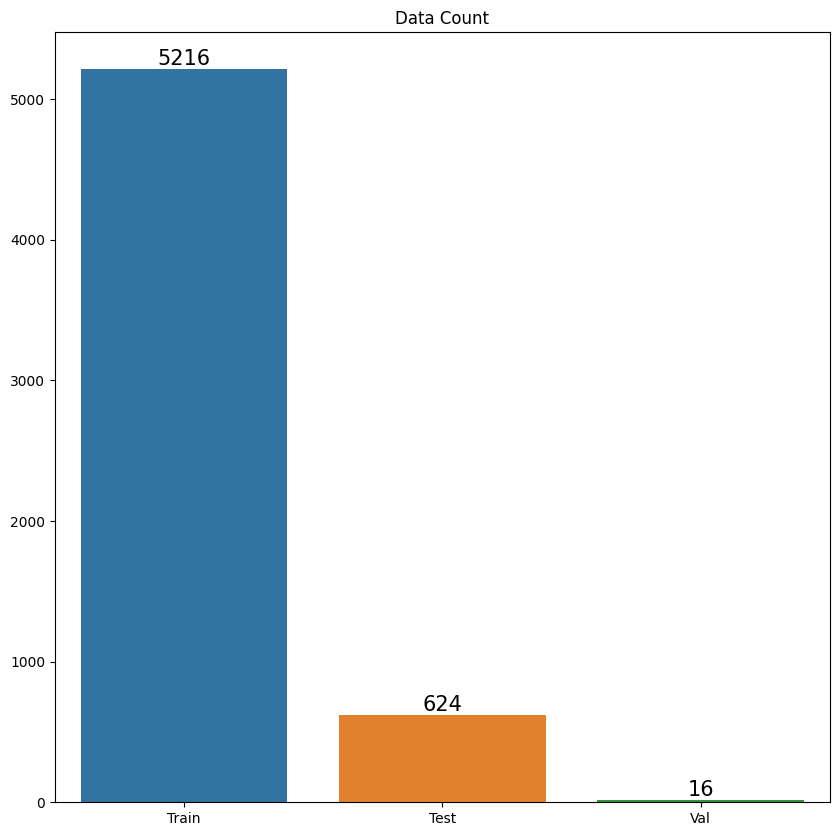

In [9]:
count_images = [train.samples,test.samples,val.samples]
text_count = ['Train','Test','Val']
fig,axes = plt.subplots(nrows=1,ncols=1,figsize = (10,10))
ax = sns.barplot(x = text_count,y=count_images,ax=axes)
for i in ax.containers:
    ax.bar_label(i,fontsize=15)
ax.set_title("Data Count")
plt.show()

In [10]:
train_labels = []
for i in range(len(train)):
    labels = train[i][1]
    train_labels.extend(labels.astype(np.int32))

In [11]:
test_labels = []
for i in range(len(test)):
    labels = test[i][1]
    test_labels.extend(labels.astype(np.int32))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

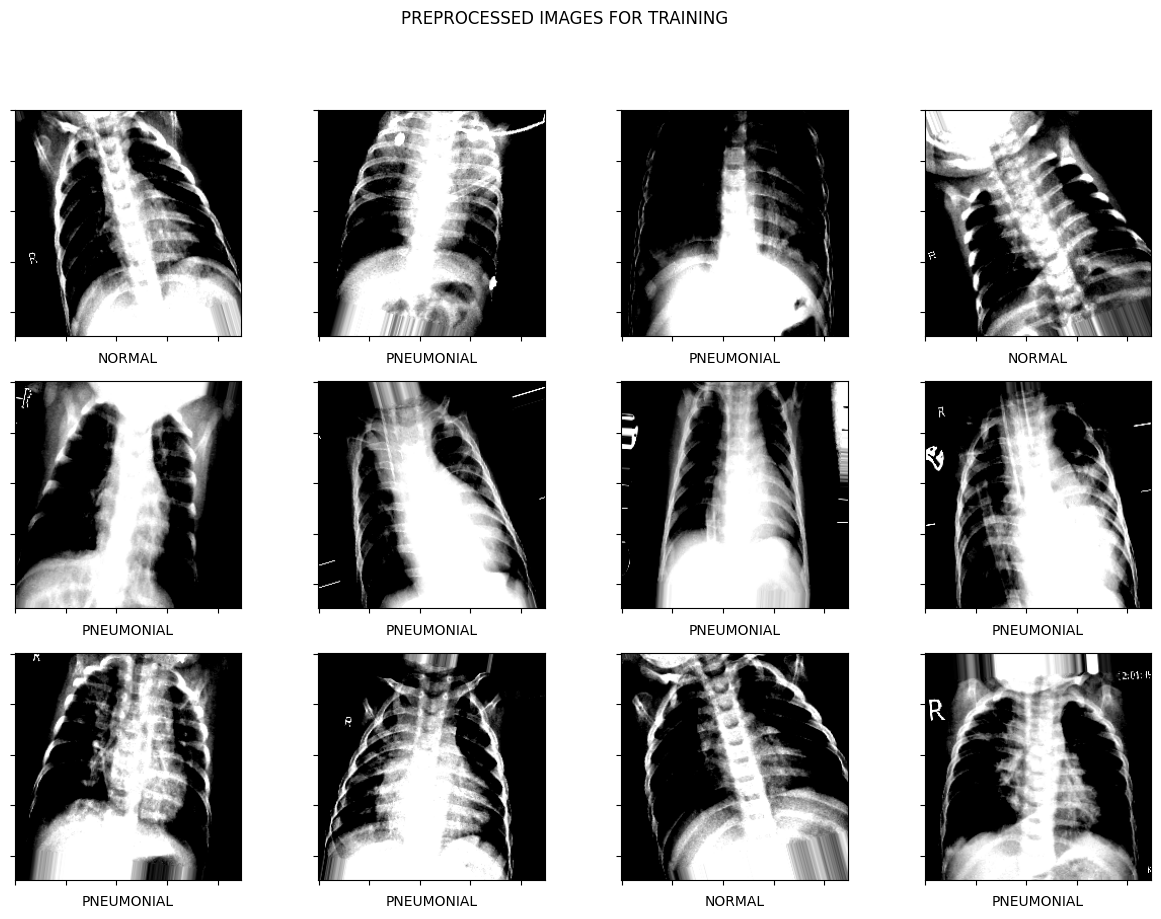

In [12]:
fig,axes = plt.subplots(nrows=3,ncols=4,figsize=(15,10))
labels = {1:"PNEUMONIAL",0:"NORMAL"}
cols=0
rows=0
for i in range(12):
    if i in [4,8]:
        rows+=1
        cols=0
    img_data,label = train.__getitem__(i)
    axes[rows][cols].imshow(img_data[0])
    axes[rows][cols].set_xticklabels([])
    axes[rows][cols].set_yticklabels([])
    axes[rows][cols].set_xlabel(labels[label[0]])
    cols+=1
fig.suptitle("PREPROCESSED IMAGES FOR TRAINING")
fig.show()

In [13]:
img_data,label = train.__getitem__(0)
print(f"The shape of each image in the dataset is {img_data[0].shape}")

The shape of each image in the dataset is (224, 224, 3)


# MODEL FORMULAITION

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

cnn1 = Sequential()
cnn1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 3)))
cnn1.add(MaxPool2D(pool_size=(2, 2)))
cnn1.add(BatchNormalization())

cnn1.add(Conv2D(64, (3, 3), activation="relu"))
cnn1.add(MaxPool2D(pool_size=(2, 2)))
cnn1.add(BatchNormalization())

cnn1.add(Flatten())
cnn1.add(Dense(64, activation='relu'))
cnn1.add(Dropout(0.2))
cnn1.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
cnn1.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

cnn1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 111, 111, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                      

In [19]:
hist = cnn1.fit_generator(
           train, 
           epochs=5, validation_data=val)

Epoch 1/5
348/348 [==============================] - 80s 224ms/step - loss: 0.8548 - accuracy: 0.7327 - val_loss: 0.8249 - val_accuracy: 0.5000
Epoch 2/5
348/348 [==============================] - 77s 221ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.8177 - val_accuracy: 0.5000
Epoch 3/5
348/348 [==============================] - 78s 223ms/step - loss: 0.5702 - accuracy: 0.7429 - val_loss: 0.8283 - val_accuracy: 0.5000
Epoch 4/5
348/348 [==============================] - 79s 226ms/step - loss: 0.5864 - accuracy: 0.7431 - val_loss: 0.8556 - val_accuracy: 0.5000
Epoch 5/5
348/348 [==============================] - 77s 220ms/step - loss: 0.5809 - accuracy: 0.7429 - val_loss: 0.8193 - val_accuracy: 0.5000


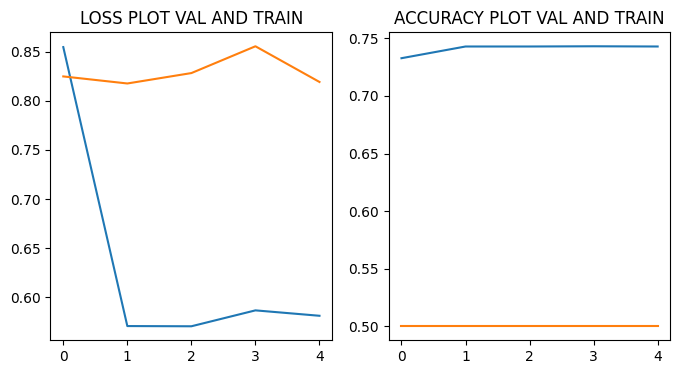

In [22]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(8,4))
axes[0].plot(hist.history['loss'],label = 'train loss')
axes[0].plot(hist.history['val_loss'],label='validation loss')
axes[0].set_title("LOSS PLOT VAL AND TRAIN")
axes[1].plot(hist.history['accuracy'],label='train accuracy')
axes[1].plot(hist.history['val_accuracy'])
axes[1].set_title("ACCURACY PLOT VAL AND TRAIN")
plt.show()

In [23]:
prediction_test_1=cnn1.evaluate(test)
prediction_train_1 = cnn1.evaluate(train)

348/348 [==============================] - 79s 228ms/step - loss: 0.5712 - accuracy: 0.7429


In [24]:
from tensorflow.keras.preprocessing.image import load_img

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from tqdm.notebook import tqdm

In [29]:
from PIL import Image
from tensorflow import keras
import tensorflow.keras.layers as k

In [30]:
from tensorflow.keras.preprocessing.image import load_img

In [31]:
os.environ['KERAS BACKEND']='tensorflow'
np.random.seed(300)

In [32]:
image_dirc=r"C:\Users\pirat\Desktop\archive (5)\chest_xray"
size=64
dataset=[]
label=[]

In [44]:
Infected_dir=os.listdir(image_dirc+"/train/PNEUMONIA/")

In [45]:
len(Infected_dir)

3875

In [46]:
not_infected=os.listdir(image_dirc+"/train/NORMAL/")

In [47]:
len(not_infected)

1341

In [48]:
for i, img_name in enumerate(Infected_dir):
    if(img_name.split('.')[1]=='jpeg'):
        image=cv2.imread(image_dirc+"/train/PNEUMONIA/"+img_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((size,size))
        
        dataset.append(np.array(image))
        label.append(1)

In [49]:
dataset[0]

array([[[24, 24, 24],
        [35, 35, 35],
        [46, 46, 46],
        ...,
        [29, 29, 29],
        [19, 19, 19],
        [ 7,  7,  7]],

       [[27, 27, 27],
        [40, 40, 40],
        [46, 46, 46],
        ...,
        [31, 31, 31],
        [21, 21, 21],
        [ 9,  9,  9]],

       [[33, 33, 33],
        [42, 42, 42],
        [44, 44, 44],
        ...,
        [32, 32, 32],
        [21, 21, 21],
        [13, 13, 13]],

       ...,

       [[10, 10, 10],
        [ 4,  4,  4],
        [ 5,  5,  5],
        ...,
        [14, 14, 14],
        [16, 16, 16],
        [16, 16, 16]],

       [[10, 10, 10],
        [ 4,  4,  4],
        [ 5,  5,  5],
        ...,
        [14, 14, 14],
        [15, 15, 15],
        [16, 16, 16]],

       [[10, 10, 10],
        [ 4,  4,  4],
        [ 5,  5,  5],
        ...,
        [13, 13, 13],
        [15, 15, 15],
        [15, 15, 15]]], dtype=uint8)

In [50]:
label[0]

1

In [51]:
for i, img_name in enumerate(not_infected):
    if(img_name.split('.')[1]=='jpeg'):
        image=cv2.imread(image_dirc+"/train/NORMAL/"+img_name)
        image=Image.fromarray(image,'RGB')
        image=image.resize((size,size))
        
        dataset.append(np.array(image))
        label.append(0)

In [52]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
X_train,X_test,Y_train,Y_test=train_test_split(dataset,to_categorical(np.array(label)),test_size=0.3,random_state=0)

In [53]:
INPUT_SHAPE=(size,size,3)
input_data=k.Input(INPUT_SHAPE)
conv1=k.Conv2D(32,kernel_size=(3,3),activation="relu",padding='same')(input_data)
pool1=k.MaxPool2D(pool_size=(2,2))(conv1)
norm1=k.BatchNormalization(axis=-1)(pool1)
drop1=k.Dropout(rate=0.1)(norm1)

#2nd convulation

conv2=k.Conv2D(32,kernel_size=(3,3),activation="relu",padding='same')(drop1)
pool2=k.MaxPool2D(pool_size=(2,2))(conv2)
norm2=k.BatchNormalization(axis=-1)(pool2)
drop2=k.Dropout(rate=0.1)(norm2)


#3rd Convulation
conv3=k.Conv2D(32,kernel_size=(3,3),activation="relu",padding='same')(drop2)
pool3=k.MaxPool2D(pool_size=(2,2))(conv3)
norm3=k.BatchNormalization(axis=-1)(pool3)
drop3=k.Dropout(rate=0.1)(norm3)


flatten=k.Flatten()(drop3)

In [54]:
#hidden Layer 1

hidden1=k.Dense(1024,activation="relu")(flatten)
norm4=k.BatchNormalization(axis=-1)(hidden1)
drop4=k.Dropout(rate=0.1)(norm4)


# Hidden Layer 2


hidden2=k.Dense(512,activation="relu")(drop4)
norm5=k.BatchNormalization(axis=-1)(hidden2)
drop5=k.Dropout(rate=0.1)(norm5)

#Hidden Layer 3

hidden3=k.Dense(256,activation="relu")(drop5)
norm6=k.BatchNormalization(axis=-1)(hidden2)
drop6=k.Dropout(rate=0.1)(norm5)


out=k.Dense(2,activation="sigmoid")(drop6)

In [55]:
from keras.losses import categorical_crossentropy

In [56]:
model=keras.Model(inputs=input_data,outputs=out)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        9248  

In [57]:
history=model.fit(np.array(X_train),Y_train,batch_size=64,verbose=1,epochs=10,validation_split=0.1,shuffle=False)

Epoch 1/10
52/52 [==============================] - 3s 27ms/step - loss: 0.3613 - accuracy: 0.9111 - val_loss: 0.6259 - val_accuracy: 0.7923
Epoch 2/10
52/52 [==============================] - 1s 18ms/step - loss: 0.1455 - accuracy: 0.9571 - val_loss: 0.1508 - val_accuracy: 0.9372
Epoch 3/10
52/52 [==============================] - 1s 18ms/step - loss: 0.0719 - accuracy: 0.9747 - val_loss: 0.0912 - val_accuracy: 0.9645
Epoch 4/10
52/52 [==============================] - 1s 18ms/step - loss: 0.0663 - accuracy: 0.9778 - val_loss: 0.1106 - val_accuracy: 0.9672
Epoch 5/10
52/52 [==============================] - 1s 18ms/step - loss: 0.0499 - accuracy: 0.9830 - val_loss: 0.1067 - val_accuracy: 0.9672
Epoch 6/10
52/52 [==============================] - 1s 18ms/step - loss: 0.0485 - accuracy: 0.9848 - val_loss: 0.0973 - val_accuracy: 0.9781
Epoch 7/10
52/52 [==============================] - 1s 18ms/step - loss: 0.0506 - accuracy: 0.9842 - val_loss: 0.5095 - val_accuracy: 0.9071
Epoch 8/10
52

In [58]:
print("Test Accuracy:{:.2f}%".format(model.evaluate(np.array(X_test),np.array(Y_test))[1]*100))



49/49 [==============================] - 1s 7ms/step - loss: 0.1594 - accuracy: 0.9655
Test Accuracy:96.55%


# new

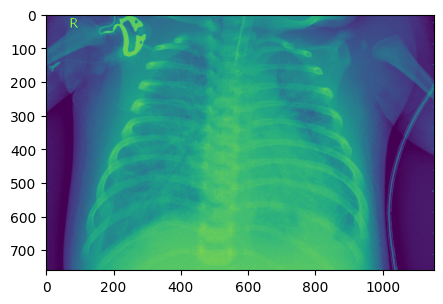

In [59]:
from glob import glob #retriving an array of files in directories
path_train = r"C:\Users\pirat\Desktop\archive (5)\chest_xray\train"
img = glob(path_train+"/PNEUMONIA/*.jpeg")
# print(img)
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

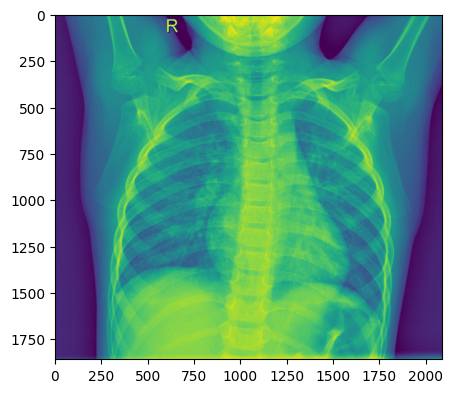

In [60]:
img = glob(path_train+"/NORMAL/*.jpeg")
img = np.asarray(plt.imread(img[0]))
plt.figure(figsize = (5 , 5))
plt.imshow(img)

In [61]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array


In [62]:
from tensorflow.keras.models import Sequential,Model

In [63]:
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Input,MaxPooling2D,Dropout,BatchNormalization

In [64]:
img_size=150
batch_size=25

traingen=ImageDataGenerator(rescale=1/255.,
                           rotation_range=50,
                        brightness_range=[0.2,1.2],
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=True)


testgen=ImageDataGenerator(rescale=1/255.)

valgen=ImageDataGenerator(rescale=1/255.)

In [65]:
traindata=traingen.flow_from_directory(r'C:\Users\pirat\Desktop\archive (5)\chest_xray\train',
                                       target_size=(img_size,img_size)
                                       ,batch_size=batch_size,
                                       shuffle=True,class_mode='binary'
                                      ,color_mode='grayscale')

testdata=testgen.flow_from_directory(r'C:\Users\pirat\Desktop\archive (5)\chest_xray\test',
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="binary",color_mode='grayscale')
valdata=valgen.flow_from_directory(r'C:\Users\pirat\Desktop\archive (5)\chest_xray\val',
                                    shuffle=False,batch_size=batch_size,
                                    target_size=(img_size,img_size),
                                    class_mode="binary",color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


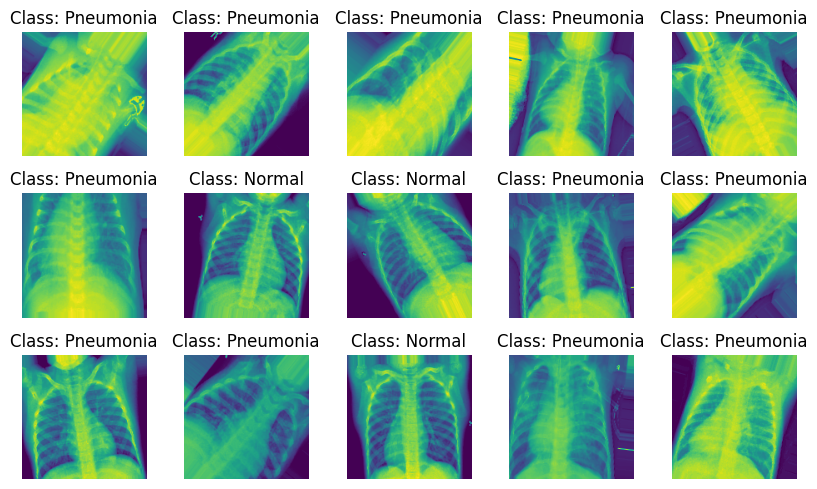

In [71]:
import matplotlib.pyplot as plt

labels = ['Normal', 'Pneumonia']
samples = traindata.__next__()

images = samples[0]
target = samples[1]

# Set the figure size to increase the size of the images
plt.figure(figsize=(10, 10))

for i in range(15):
    plt.subplot(5, 5, i+1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    plt.title(f"Class: {labels[int(target[i])]}")
    plt.axis('off')

plt.show()


In [72]:
df=pd.DataFrame(traindata.classes)
df.value_counts()

1    3875
0    1341
Name: count, dtype: int64

In [73]:
df=pd.DataFrame(valdata.classes)
df.value_counts()

0    8
1    8
Name: count, dtype: int64

In [74]:
df=pd.DataFrame(testdata.classes)
df.value_counts()

1    390
0    234
Name: count, dtype: int64

In [75]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
model=Sequential()
model.add(Conv2D(32,(2,2),input_shape=(img_size,img_size,1),activation="relu",padding='same',strides=1))
model.add(MaxPooling2D())
model.add(Conv2D(64,(2,2),strides=2,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128,(2,2),strides=1,activation="relu",padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(1,activation='sigmoid'))

In [76]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 150, 150, 32)      160       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 38, 38, 64)        8256      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 19, 19, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 19, 19, 128)       32896     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 9, 9, 128)       

In [77]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
filepath= "model_cnn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
# es = EarlyStopping(monitor='accuracy', patience=5)

In [79]:
history=model.fit(traindata,validation_data=valdata,epochs=15,callbacks=[checkpoint])

Epoch 1/15
209/209 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7617
Epoch 1: val_loss improved from inf to 1.21162, saving model to model_cnn.h5
209/209 [==============================] - 30s 140ms/step - loss: 0.5059 - accuracy: 0.7617 - val_loss: 1.2116 - val_accuracy: 0.5625
Epoch 2/15
209/209 [==============================] - ETA: 0s - loss: 0.3162 - accuracy: 0.8554
Epoch 2: val_loss improved from 1.21162 to 1.06831, saving model to model_cnn.h5
209/209 [==============================] - 29s 140ms/step - loss: 0.3162 - accuracy: 0.8554 - val_loss: 1.0683 - val_accuracy: 0.7500
Epoch 3/15
209/209 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.8819
Epoch 3: val_loss improved from 1.06831 to 0.79879, saving model to model_cnn.h5
209/209 [==============================] - 29s 137ms/step - loss: 0.2762 - accuracy: 0.8819 - val_loss: 0.7988 - val_accuracy: 0.7500
Epoch 4/15
209/209 [==============================] - ETA: 0s - loss: 0

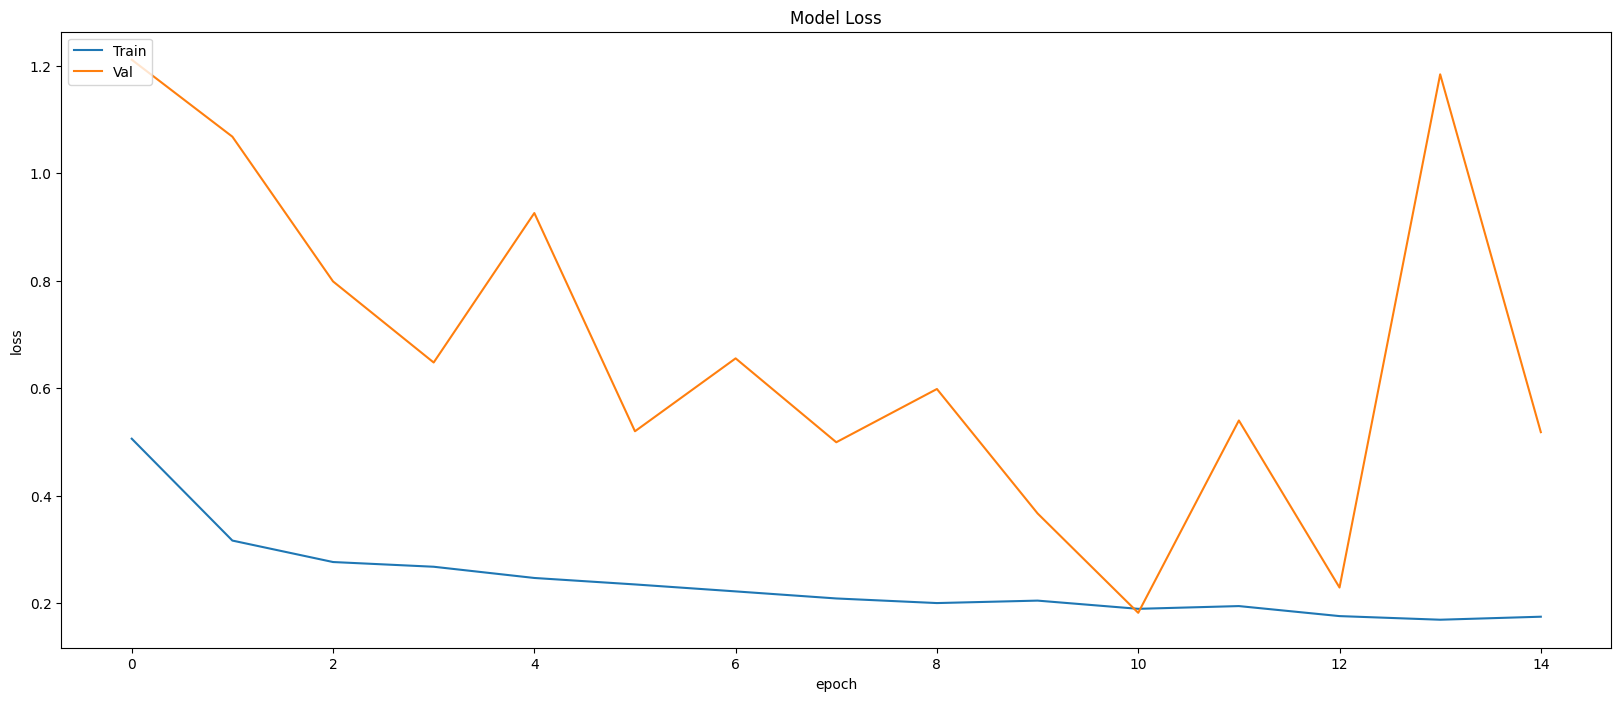

In [80]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

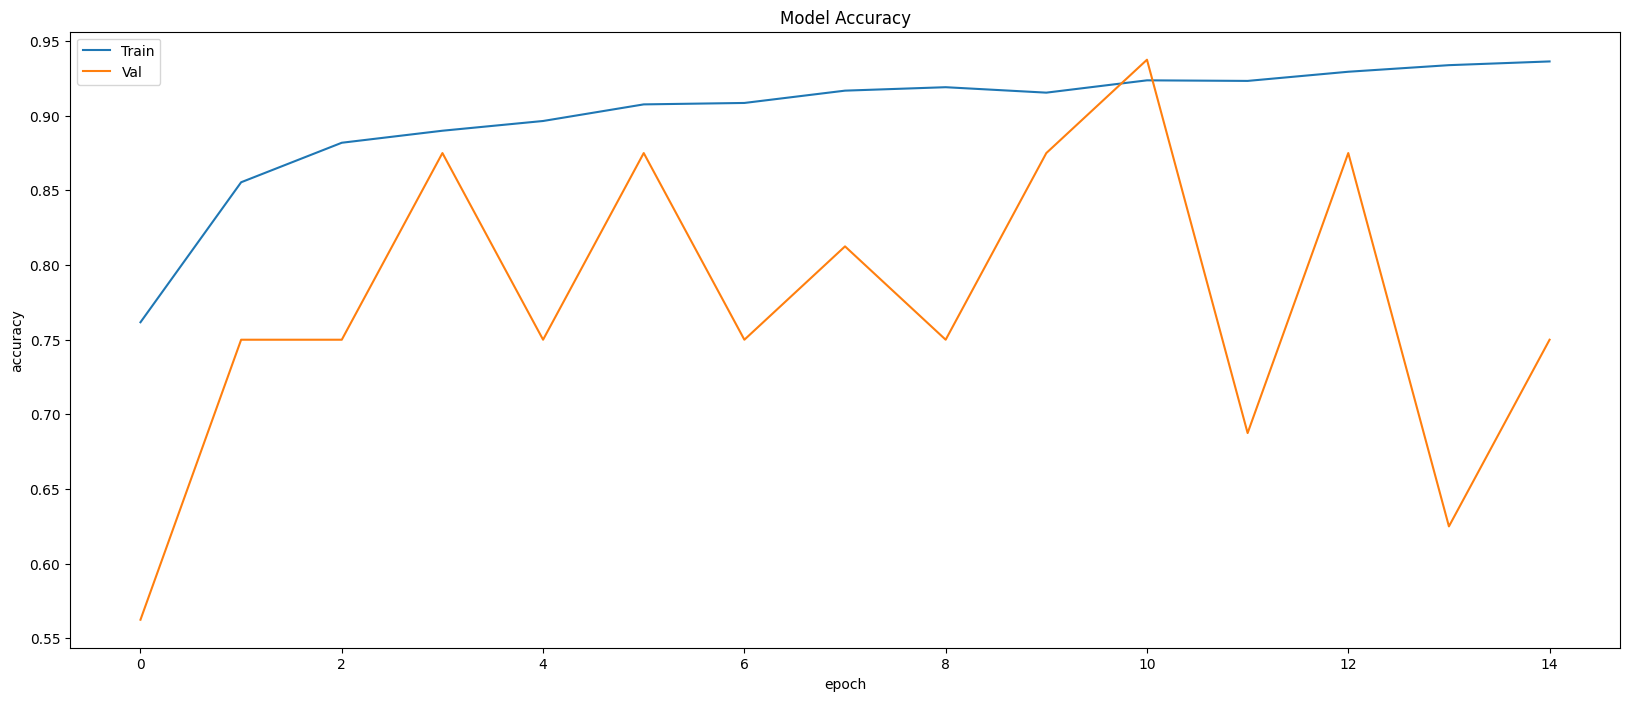

In [81]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [82]:
y_test = valdata.classes
y_pred = model.predict(valdata)
y_pred_probs = y_pred.copy()
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

1/1 [==============================] - 0s 198ms/step


In [83]:
from sklearn.metrics import classification_report, confusion_matrix

In [84]:
print(classification_report(y_test,y_pred,target_names = ['Normal','Pnuemonia']))

              precision    recall  f1-score   support

      Normal       1.00      0.50      0.67         8
   Pnuemonia       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



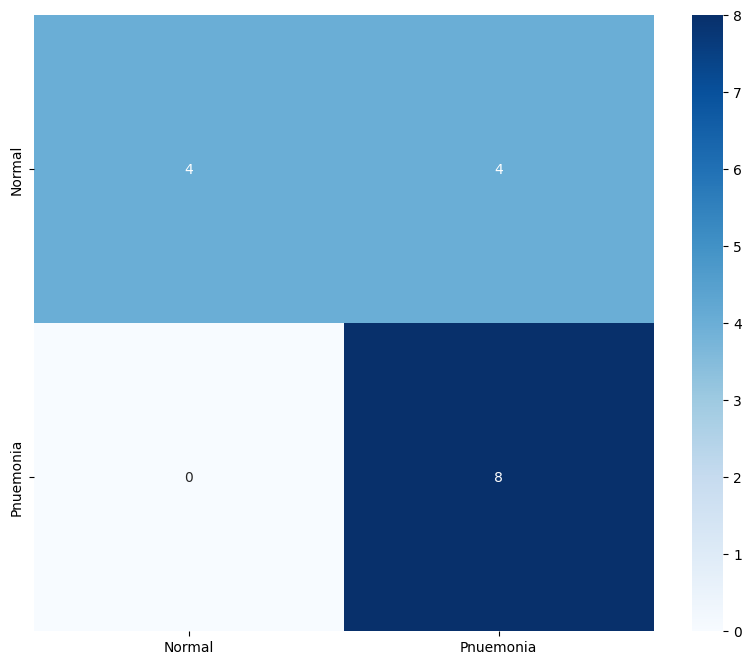

In [85]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['Normal','Pnuemonia'],
            yticklabels=['Normal','Pnuemonia'],cmap='Blues')
plt.show()

In [86]:
y_test = testdata.classes
y_pred = model.predict(testdata)
y_pred_probs = y_pred.copy()

25/25 [==============================] - 3s 98ms/step


In [87]:
y_pred[y_pred>0.5] = 1
y_pred[y_pred<0.5] = 0

In [88]:
from sklearn.metrics import classification_report, confusion_matrix

In [89]:
print(classification_report(y_test,y_pred,target_names = ['Normal','Pnuemonia']))

              precision    recall  f1-score   support

      Normal       0.93      0.65      0.76       234
   Pnuemonia       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



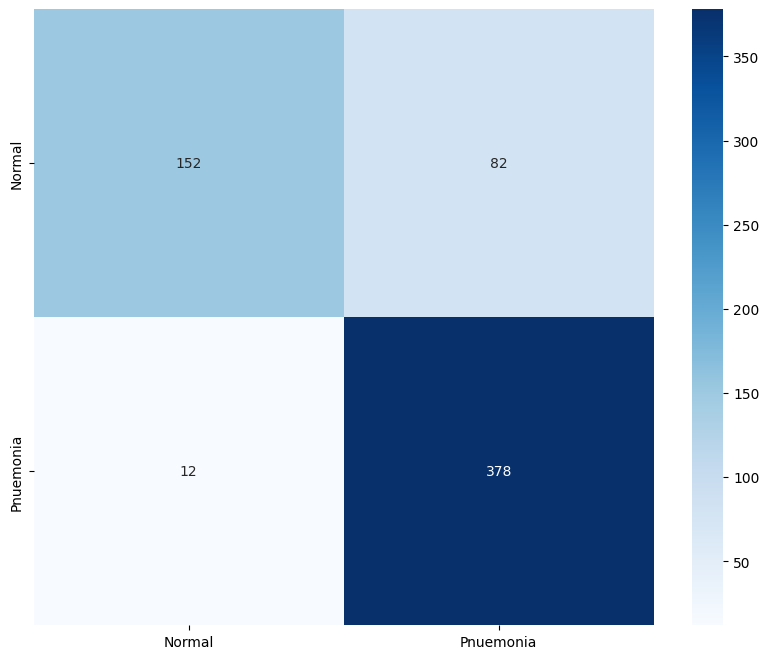

In [90]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.3g',xticklabels=['Normal','Pnuemonia'],
            yticklabels=['Normal','Pnuemonia'],cmap='Blues')
plt.show()

In [91]:
filenames = testdata.filenames
data = pd.DataFrame()
data['filename'] = filenames
data['actual_class'] = y_test
data['predicted_class'] = y_pred
data['predicted_prob'] = y_pred_probs

In [92]:
misclassification = data[data['actual_class']!=data['predicted_class']]

In [93]:
misclassification[(misclassification['actual_class']==0) & (misclassification['predicted_prob']>0.9)]

,filename,actual_class,predicted_class,predicted_prob
3,NORMAL\IM-0006-0001.jpeg,0,1.0,0.929513
26,NORMAL\IM-0033-0001.jpeg,0,1.0,0.930680
40,NORMAL\IM-0065-0001.jpeg,0,1.0,0.974819
47,NORMAL\IM-0077-0001.jpeg,0,1.0,0.967530
49,NORMAL\IM-0081-0001.jpeg,0,1.0,0.943534
113,NORMAL\NORMAL2-IM-0145-0001.jpeg,0,1.0,0.979491
119,NORMAL\NORMAL2-IM-0195-0001.jpeg,0,1.0,0.992323
120,NORMAL\NORMAL2-IM-0196-0001.jpeg,0,1.0,0.977375
121,NORMAL\NORMAL2-IM-0198-0001.jpeg,0,1.0,0.999846
122,NORMAL\NORMAL2-IM-0199-0001.jpeg,0,1.0,0.985155


In [94]:
misclassification[(misclassification['actual_class']==1) & (misclassification['predicted_prob']<0.5)]

,filename,actual_class,predicted_class,predicted_prob
254,PNEUMONIA\person108_bacteria_511.jpeg,1,0.0,0.297724
284,PNEUMONIA\person118_bacteria_560.jpeg,1,0.0,0.359746
317,PNEUMONIA\person127_bacteria_604.jpeg,1,0.0,0.144965
388,PNEUMONIA\person152_bacteria_724.jpeg,1,0.0,0.401314
390,PNEUMONIA\person153_bacteria_726.jpeg,1,0.0,0.173303
391,PNEUMONIA\person154_bacteria_728.jpeg,1,0.0,0.017623
417,PNEUMONIA\person161_bacteria_762.jpeg,1,0.0,0.346593
476,PNEUMONIA\person172_bacteria_828.jpeg,1,0.0,0.207387
479,PNEUMONIA\person173_bacteria_831.jpeg,1,0.0,0.216587
496,PNEUMONIA\person21_virus_53.jpeg,1,0.0,0.183257
